<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Read-CSVs-into-Dask-Dataframe" data-toc-modified-id="Read-CSVs-into-Dask-Dataframe-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Read CSVs into Dask Dataframe</a></span></li><li><span><a href="#XGBoost-model" data-toc-modified-id="XGBoost-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>XGBoost model</a></span></li><li><span><a href="#XGBoost-model-with-train-test-split" data-toc-modified-id="XGBoost-model-with-train-test-split-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>XGBoost model with train-test split</a></span></li><li><span><a href="#Dask-delayed,-sampling-CSV-rows-with-.sample()" data-toc-modified-id="Dask-delayed,-sampling-CSV-rows-with-.sample()-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dask delayed, sampling CSV rows with .sample()</a></span></li><li><span><a href="#More-testing-of-read_csv-and-merge-(can-ignore-this-section)" data-toc-modified-id="More-testing-of-read_csv-and-merge-(can-ignore-this-section)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>More testing of read_csv and merge (can ignore this section)</a></span></li><li><span><a href="#Test-reading-sample-from-multiple-CSVs" data-toc-modified-id="Test-reading-sample-from-multiple-CSVs-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Test reading sample from multiple CSVs</a></span></li><li><span><a href="#Create-a-list-of-delayed-objects-from-multiple-CSVs-and-work-with-them-to-create-train-and-test-sets" data-toc-modified-id="Create-a-list-of-delayed-objects-from-multiple-CSVs-and-work-with-them-to-create-train-and-test-sets-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Create a list of delayed objects from multiple CSVs and work with them to create train and test sets</a></span></li></ul></div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# set up client with 2 workers, each having two threads and each having a 2GB memory limit
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=2, memory_limit='2GB')
client

Client Scheduler: tcp://127.0.0.1:61210 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 4.00 GB


In [3]:
from dask import dataframe as dd, array as da

##### Read CSVs into Dask Dataframe

In [4]:
ddf = dd.read_csv('../data/test/csv*.csv', parse_dates=['date']).set_index('date')
ddf

,y,x
npartitions=2,,
2015-01-01,float64,float64
2019-01-01,...,...
2021-09-26,...,...


##### XGBoost model

In [5]:
import xgboost as xgb

In [8]:
X = ddf['x'].to_dask_array(lengths=True).reshape(-1,1)
y = ddf['y']

In [9]:
dtrain = xgb.dask.DaskDMatrix(client, X, y)

In [53]:
result = xgb.dask.train(
    client=client,
    params={
        "objective": "reg:squarederror",
    },
    dtrain=dtrain,
    num_boost_round=10,
    evals=[(dtrain, "train")],
    early_stopping_rounds=5
)

In [54]:
print(result['history'])

{'train': {'rmse': [15.956649, 11.227454, 7.914044, 5.603489, 3.998896, 2.898554, 2.15791, 1.675652, 1.375932, 1.200241]}}


In [55]:
result['booster'].best_ntree_limit

10

In [56]:
result['booster'].best_score

1.200241

In [57]:
result['booster'].best_iteration

9

In [58]:
result['booster'].best_ntree_limit

10

##### XGBoost model with train-test split

In [43]:
from dask_ml.model_selection import train_test_split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(ddf.x, ddf.y, shuffle=False)

In [46]:
X_train = X_train.to_dask_array(lengths=True).reshape(-1,1)
X_test = X_test.to_dask_array(lengths=True).reshape(-1,1)

In [47]:
dtrain2 = xgb.dask.DaskDMatrix(client, X_train, y_train)

In [48]:
dtest = xgb.dask.DaskDMatrix(client, X_test, y_test)

In [63]:
%time

result2 = xgb.dask.train(
    client=client,
    params={
        "objective": "reg:squarederror",
    },
    dtrain=dtrain2,
    num_boost_round=10,
#     evals=[(dtrain2, "train"), (dtest, "test")],
    evals=[(dtest, "test")],
    early_stopping_rounds=5
)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


In [64]:
print(result2['history'])

{'test': {'rmse': [16.538439, 11.678191, 8.278107, 5.887934, 4.221953, 3.06977, 2.304125, 1.801274, 1.486173, 1.30199]}}


In [65]:
# next:
# run validation on multiple test sets using time series split (moving window approach)
# report average score across all test sets
# place the reporting inside a loop over hyperparameter values, producing a summary of the best set of hyperparameters
# and corresponding average score

In [66]:
# also figure out what to do about the DaskDMatrix creation requiring evalution of preceding tasks

In [67]:
# may need to write a model class that operates on different objects

##### Dask delayed, sampling CSV rows with .sample()

In [70]:
from dask import delayed

In [231]:
# load data as part of computation rather than doing it locally
def read_csv(path, frac=.4):
    return dd.read_csv(path, parse_dates=['date']).set_index('date').sample(frac=frac, random_state=1)

x = delayed(read_csv)('../data/test/csv*.csv')

In [260]:
x

Delayed('read_csv-5fae1ad0-8ad0-487d-a525-a6eff4efcd33')

In [261]:
dd.from_delayed(x)

,y,x
npartitions=1,,
,float64,float64
,...,...


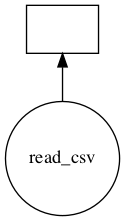

In [166]:
x.visualize()

In [196]:
x.compute()

,y,x
npartitions=2,,
2015-01-01,float64,float64
2019-01-01,...,...
2021-09-26,...,...


In [198]:
from dask import is_dask_collection
is_dask_collection(x.compute())

True

In [77]:
ddf

,y,x
npartitions=2,,
2015-01-01,float64,float64
2019-01-01,...,...
2021-09-26,...,...


In [232]:
from dask.distributed import performance_report

with performance_report():
    ddf_sample = dd.from_delayed(x, verify_meta=False)

In [163]:
type(ddf_sample.compute().compute())

pandas.core.frame.DataFrame

In [195]:
# ddf_sample.persist().compute().visualize()
# ddf_sample.persist().dask
# client.persist(ddf_sample)
# client.scheduler_info()

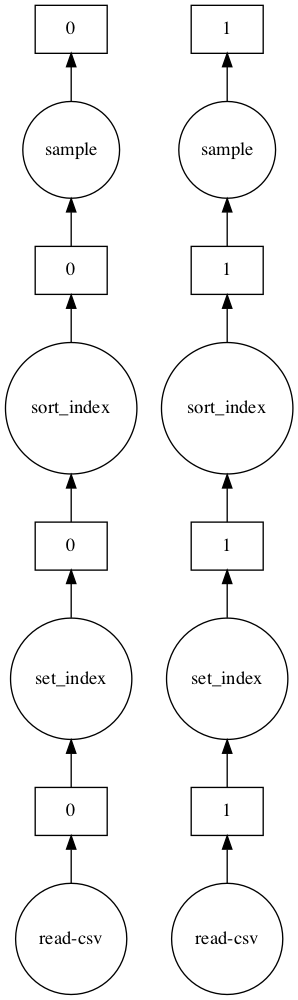

In [183]:
ddf_sample.compute().visualize()

In [168]:
ddf_sample.compute().compute()

,y,x
date,,
2016-03-17,8.831639,-8.82
2015-02-21,0.317419,-1.02
2015-03-19,0.980404,-1.54
2015-09-03,3.875713,-4.90
2016-05-23,10.208258,-10.16
...,...,...
2020-12-25,34.059202,-34.48
2021-01-21,35.272452,-35.02
2020-02-11,26.226510,-28.12


In [158]:
ddf_sample['x'].compute().to_dask_array(lengths=True).reshape(-1,1)

dask.array<reshape, shape=(800, 1), dtype=float64, chunksize=(400, 1), chunktype=numpy.ndarray>

In [159]:
ddf_sample['y'].compute()

Dask Series Structure:
npartitions=2
2015-01-01    float64
2019-01-01        ...
2021-09-26        ...
Name: y, dtype: float64
Dask Name: getitem, 10 tasks

In [169]:
# still not sure what exactly happens when .compute() is called on a from_delayed object
X_sample_train = ddf_sample['x'].compute().to_dask_array(lengths=True).reshape(-1,1)
y_sample_train = ddf_sample['y'].compute()
xgb.dask.DaskDMatrix(client, X_sample_train, y_sample_train)

##### More testing of read_csv and merge (can ignore this section)

In [81]:
ddf_sub = ddf.loc[(ddf.index <= pd.Timestamp('2018-12-31'))]

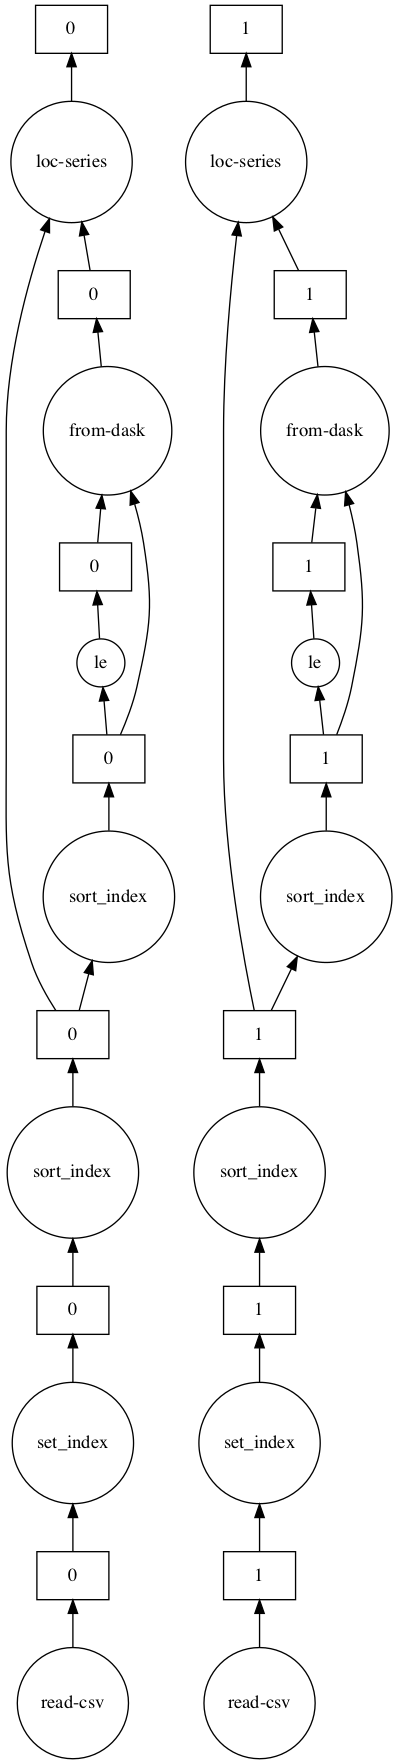

In [82]:
ddf_sub.visualize()

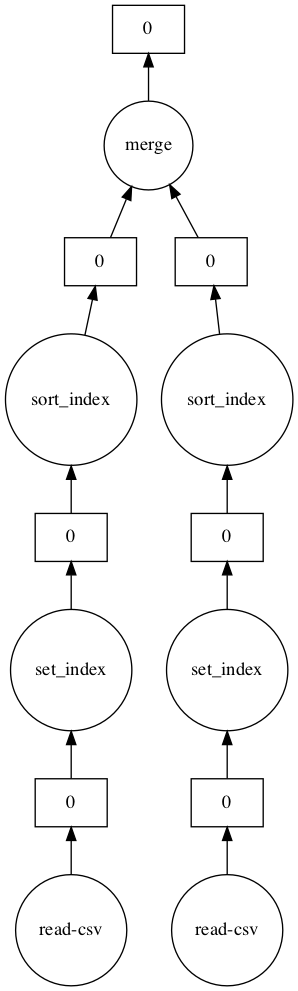

In [83]:
ddf1 = dd.read_csv('../data/test/csv1.csv', parse_dates=['date']).set_index('date')
ddf2 = dd.read_csv('../data/test/csv2.csv', parse_dates=['date']).set_index('date')

ddf_all = dd.merge(ddf1, ddf2)
ddf_all.visualize()

##### Test reading sample from multiple CSVs

In [99]:
ddf_sample = dd.read_csv(
    '../data/test/csv*.csv',
    parse_dates=['date'],
).set_index('date').sample(frac=0.5)

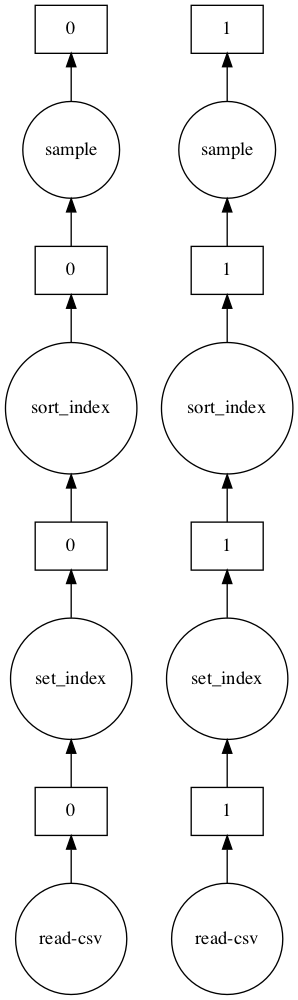

In [102]:
ddf_sample.visualize()

In [164]:
# skiprows in Dask does not accept a callable, so the code below will not work

# import random

# ddf_sample = dd.read_csv(
#     '../data/test/csv*.csv',
#     parse_dates=['date'],
#     skiprows=lambda i: i>0 and random.random() > 0.5
# ).set_index('date')

##### Create a list of delayed objects from multiple CSVs and work with them to create train and test sets

In [224]:
import os

In [ ]:
# from glob import glob
# import os

# lazy_dataframes = []
# for directory in glob('2016-*'):
#     for symbol in os.listdir(directory):
#         filename = os.path.join(directory, symbol)
#         df = delayed(feather.read_dataframe)(filename)
#         df = delayed(pd.DataFrame.assign)(df, date=pd.Timestamp(directory),
#                                               symbol=symbol)
#         lazy_dataframes.append(df)

In [277]:
def read_csv_file(path, frac=1.):
    return dd.read_csv(path, parse_dates=['date']).set_index('date').sample(frac=frac, random_state=1)
#     return dd.read_csv(path, parse_dates=['date']).sample(frac=frac, random_state=1)


# per https://gist.github.com/mrocklin/e7b7b3a65f2835cda813096332ec73ca
lazy_dataframes = []
directory = '../data/test/'
for csv_file in os.listdir(directory):
    filename = os.path.join(directory, csv_file)
    df = delayed(read_csv_file)(filename)
    lazy_dataframes.append(df)
    
lazy_dataframes[0]

Delayed('read_csv_file-777018d0-9ec0-4f67-83c4-f798b6d85209')

In [278]:
dd.from_delayed(lazy_dataframes)

,y,x
npartitions=2,,
,float64,float64
,...,...
,...,...


In [258]:
dd.from_delayed(lazy_dataframes[1], verify_meta=False).compute()

,y,x
npartitions=1,,
2019-01-01,float64,float64
2021-09-26,...,...


In [279]:
lazy_dataframes[0].compute().divisions

(Timestamp('2015-01-01 00:00:00'), Timestamp('2017-09-26 00:00:00'))

In [283]:
# per https://docs.dask.org/en/latest/delayed-collections.html
dd.compute(*lazy_dataframes)

(Dask DataFrame Structure:
                      y        x
 npartitions=1                  
 2015-01-01     float64  float64
 2017-09-26         ...      ...
 Dask Name: sample, 4 tasks,
 Dask DataFrame Structure:
                      y        x
 npartitions=1                  
 2019-01-01     float64  float64
 2021-09-26         ...      ...
 Dask Name: sample, 4 tasks)

In [290]:
# length of tuple
len(dd.compute(*lazy_dataframes))

2

In [291]:
dd.compute(*lazy_dataframes)[0]

,y,x
npartitions=1,,
2015-01-01,float64,float64
2017-09-26,...,...


In [298]:
# get the first dask dataframe from the tuple and call compute() to get pandas dataframe
dd.compute(*lazy_dataframes)[0].compute()

,y,x
date,,
2016-03-17,8.831639,-8.82
2015-02-21,0.317419,-1.02
2015-03-19,0.980404,-1.54
2015-09-03,3.875713,-4.90
2016-05-23,10.208258,-10.16
...,...,...
2015-06-13,4.561750,-3.26
2015-08-25,5.537348,-4.72
2015-04-23,1.716608,-2.24


In [289]:
dd.compute(lazy_dataframes[0])[0].compute()

,y,x
date,,
2016-03-17,8.831639,-8.82
2015-02-21,0.317419,-1.02
2015-03-19,0.980404,-1.54
2015-09-03,3.875713,-4.90
2016-05-23,10.208258,-10.16
...,...,...
2015-06-13,4.561750,-3.26
2015-08-25,5.537348,-4.72
2015-04-23,1.716608,-2.24


In [300]:
# dd.from_delayed(lazy_dataframes, verify_meta=False).compute()
# Produces:
# TypeError: No dispatch for <class 'dask.dataframe.core.DataFrame'>

In [273]:
ddf_from_delayed = dd.from_delayed(lazy_dataframes, meta=lazy_dataframes[0].compute())
ddf_from_delayed
# lazy_dataframes[0].compute().compute()

,y,x
npartitions=2,,
,float64,float64
,...,...
,...,...


In [274]:
ddf_from_delayed.divisions

(None, None, None)

In [299]:
# ddf_from_delayed.compute()
# Produces:
# ValueError: Metadata mismatch found in `from_delayed`.
# Expected partition of type `pandas.core.frame.DataFrame` but got `dask.dataframe.core.DataFrame`

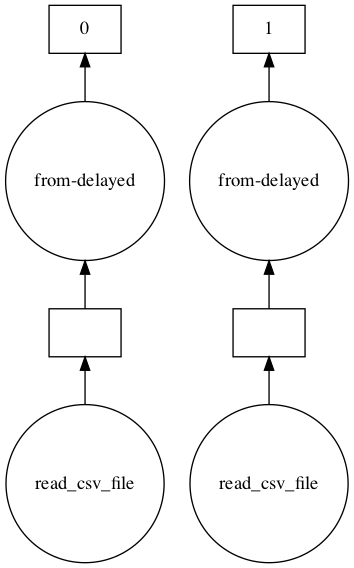

In [253]:
ddf_from_delayed.visualize()

In [309]:
# create X and y from first Dask dataframe in the lazy_dataframes list
X_train_2 = dd.compute(*lazy_dataframes)[0]['x'].to_dask_array(lengths=True).reshape(-1,1)
y_train_2 = dd.compute(*lazy_dataframes)[0]['y']

In [310]:
xgb.dask.DaskDMatrix(client, X_train_2, y_train_2)

In [311]:
%time

result3 = xgb.dask.train(
    client=client,
    params={
        "objective": "reg:squarederror",
    },
    dtrain=xgb.dask.DaskDMatrix(client, X_train_2, y_train_2),
    num_boost_round=10,
#     evals=[(dtrain2, "train"), (dtest, "test")],
#     evals=[(dtest, "test")],
#     early_stopping_rounds=5
)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 41 µs


In [317]:
result3['booster'].best_ntree_limit

10

In [319]:
# ddf_from_delayed['x'].compute().to_dask_array(lengths=True).reshape(-1,1)
# Produces:
# ValueError: Metadata mismatch found in `from_delayed`.
# Expected partition of type `pandas.core.frame.DataFrame` but got `dask.dataframe.core.DataFrame`

In [306]:
# dd.compute(*lazy_dataframes)[0].compute()
dd.concat([dd.compute(*lazy_dataframes)[0], dd.compute(*lazy_dataframes)[1]])['x']

Dask Series Structure:
npartitions=2
2015-01-01    float64
2019-01-01        ...
2021-09-26        ...
Name: x, dtype: float64
Dask Name: getitem, 12 tasks

In [321]:
x_dask_ser = dd.concat([dd.compute(*lazy_dataframes)[0], dd.compute(*lazy_dataframes)[1]])['x']
x_dask_arr = x_dask_ser.to_dask_array(lengths=True).reshape(-1,1)
y_dask_ser = dd.concat([dd.compute(*lazy_dataframes)[0], dd.compute(*lazy_dataframes)[1]])['y']
xgb.dask.DaskDMatrix(client, x_dask_arr, y_dask_ser)

In [302]:
# dd.compute(ddf_from_delayed.get_partition(1))
# Produces:
# ValueError: Metadata mismatch found in `from_delayed`.
# Expected partition of type `pandas.core.frame.DataFrame` but got `dask.dataframe.core.DataFrame`

In [ ]:
# need to specify which CSVs are loaded
# load each CSV only once and re-use for different train-validation splits
# load each CSV with its own read_csv call and then concatenate as needed to create train and validation sets
# OR NOT LOAD EACH CSV WITH ITS OWNS READ_CSV CALL, BUT CREATE A SINGLE BIG PARTITIONED DATAFRAME OUT OF ALL FILES
# AND THEN TAKE THE NEEDED SECTIONS FOR FURTHER PROCESSING
# perform dd.concat() to concatenate different from_delayed objects to create specific train and validation sets
# (potentially perform repartitioning of concatenated dataframe with .repartition(npartitions=__))


# READ_CSV: INCLUDE ENCODING= AND BLOCKSIZE= ARGUMENTS (blocksize will translate into X partitions)
# ENCODING:
# https://docs.python.org/3/library/codecs.html#standard-encodings
# Encoding to use for UTF when reading/writing (ex. ‘utf-8’).
# ALSO SPECIFY DTYPES
# df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
#                  parse_dates={'Date': [0, 1, 2]},
#                  dtype={'TailNum': str,
#                         'CRSElapsedTime': float,
#                         'Cancelled': bool})
# ALSO, DD.READ_CSV HAS A SAMPLE= PARAMETER? - this parameter is used to determine dtypes
# The more partitions we have, the more tasks we will need for each computation.

In [ ]:
# def read_train_csvs(path, frac=1.):
#     return dd.read_csv(path, parse_dates=['date']).set_index('date').sample(frac=frac, random_state=1)

# def read_train_csvs(path, frac=1.):
#     return dd.read_csv(path, parse_dates=['date']).set_index('date').sample(frac=frac, random_state=1)

# train = delayed(read_train_csvs)('../data/test/csv*.csv', 0.5)

In [201]:
import sys

In [223]:
# dtrain2 = xgb.dask.DaskDMatrix(client, X_train, y_train)
# sys.getsizeof(xgb.dask.DaskDMatrix(client, X_sample_train, y_sample_train))
# sys.getsizeof(X_sample_train)
# sys.getsizeof(da.concatenate([X_sample_train, X_sample_train]))
# sys.getsizeof(xgb.dask.DaskDMatrix(client, da.concatenate([X_sample_train, X_sample_train]),
#                                   da.concatenate([y_sample_train, y_sample_train])))

56

In [ ]:
# result2 = xgb.dask.train(
#     client=client,
#     params={
#         "objective": "reg:squarederror",
#     },
#     dtrain=dtrain2,
#     num_boost_round=10,
# #     evals=[(dtrain2, "train"), (dtest, "test")],
#     evals=[(dtest, "test")],
#     early_stopping_rounds=5
# )

In [ ]:
# def time_split(data, date):
# #     return (data.loc[(data.index <= date)].repartition(freq='1m'), 
#     return (data.loc[(data.index <= date)], 
#             data.loc[(data.index > date) & (data.index < date + pd.offsets.MonthEnd(1))])

# def sgd_regr(train, testX):
#     estimator = SGDRegressor(fit_intercept=True)
#     clf = Incremental(estimator)
#     train = cull_empty_partitions(train)
#     trainX = train['x']
#     trainy = train['y']
#     clf.fit(trainX.to_dask_array(lengths=True).reshape(-1, 1), trainy.to_dask_array(lengths=True))
#     testX = cull_empty_partitions(testX)
#     yhat = clf.predict(testX.to_dask_array(lengths=True).reshape(-1, 1))
#     return yhat

# def walk_forward_validation(data):
#     predictions = None
#     truey = None
#     # calculate number of calendar months to be used for testing
#     n_months = (
#         ((pd.Timestamp('2018-12-31') + pd.DateOffset(days=500)).year - pd.Timestamp('2018-12-31').year) * 12 +
#         (pd.Timestamp('2018-12-31') + pd.DateOffset(days=500)).month - pd.Timestamp('2018-12-31').month
#     )
#     print(n_months)
#     mse = list()
# #     fig, axs = plt.subplots(1, n_months, subplot_kw=dict(box_aspect=1), figsize=(15, 3), sharey=True, sharex=True, facecolor='w', edgecolor='k')
# #     fig, axs = plt.subplots(n_months // 5 + 1, min(n_months, 5), subplot_kw=dict(box_aspect=1), figsize=(16,3 * (n_months // 5 + 1)), sharey=True, sharex=True, facecolor='w', edgecolor='k')
#     fig, axs = plt.subplots(n_months // 5 + 1, min(n_months, 5), subplot_kw=dict(box_aspect=1), figsize=(16,3 * (n_months // 5 + 1)), facecolor='w', edgecolor='k')
#     # Supply the limits
# #     wbound = 15
# #     ebound = 25
# #     sbound = 15
# #     nbound = 25
# #     plt.xlim(wbound, ebound)
# #     plt.ylim(sbound, nbound)
#     fig.subplots_adjust(hspace = .5, wspace=.05)
#     axs = axs.ravel()
#     for a in range(n_months, len(axs)):
#         fig.delaxes(axs[a])
    
#     for m in range(n_months):
#         end_date = pd.Timestamp('2018-12-31') + pd.DateOffset(months=m)
#         train, test = time_split(data, end_date)
#         testX, testy = test['x'], test['y']
        
#         # this part not used because concatenation of arrays of different lengths does not work
# #         if truey is None:
# #             truey = testy.to_dask_array(lengths=True).reshape(-1, 1)
# #         else:
# #             truey = da.concatenate([truey, testy.to_dask_array(lengths=True).reshape(-1, 1)], axis=1)
        
#         yhat = sgd_regr(train, testX)
#         if predictions is None:
#             predictions = yhat
#         else:
#             predictions = da.concatenate([predictions, yhat])
#         mse.append(mean_squared_error(testy, yhat))
        
#         axs[m].plot(testy.to_dask_array(lengths=True), label='Actual')
# #         axs[m].set_box_aspect(1)
#         axs[m].plot(yhat, label='Predicted')
# #         axs[m].legend(loc='lower right')
#         axs[m].set_title(f"Test: {(pd.Timestamp('2018-12-31') + pd.DateOffset(months=m) + pd.DateOffset(days=1)).to_period('M').strftime('%Y-%m')}")
#         if m == n_months - 1:
#             handles, labels = axs[m].get_legend_handles_labels()
#             axs[m].legend(handles, labels)
# #         axs[m].scatter(testy.to_dask_array(lengths=True), yhat)
# #     return mse, truey, predictions 
#     return mse